<a href="https://colab.research.google.com/github/richardwsnyder/CAP-5610/blob/master/hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset
Following the google instructions in mledu

In [0]:
from keras import backend as K
# on each run of the program, reset the session
K.clear_session()

In [91]:
# get the dataset
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2019-04-18 03:05:40--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 2607:f8b0:400e:c09::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   124MB/s    in 0.5s    

2019-04-18 03:05:41 (124 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
# unzip the file to local tmp directory
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [0]:
# create directories for training and validation
# sets
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# dog and cat training and validation sets
train_dogs_dir = os.path.join(train_dir, 'dogs')
train_cats_dir = os.path.join(train_dir, 'cats')

validation_dogs_dir = os.path.join(validation_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Problem 1
Run VGG19 with data augmentation on dogs and cats dataset

In [0]:
# load the VGG19 model
from keras.applications import VGG19

conv_base = VGG19(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3)) # input images are 150x150

In [95]:
from keras import layers
from keras import models
from keras import optimizers

# initial layer is the preconfigured 
# VGG19 model
layer = conv_base.output

# flatten that layer
layer = layers.Flatten()(layer)
layer = layers.Dense(256, activation='relu')(layer)
layer = layers.Dropout(0.4)(layer)

# output is a single node that is 
# used for binary classification
layer = layers.Dense(1, activation='sigmoid')(layer)
model = models.Model(inputs=[conv_base.input], outputs=[layer])

# this will be used later for fine tuning
# states that the layers that I add, not the 
# VGG layers, are trainable (change the weights)
for idx,layer in enumerate(model.layers):
    layer.trainable = idx >= 22

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [96]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

# binary cross entropy to categorize
# images for two classes
model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.Adam(lr=2e-5), 
    metrics=['acc'])

# create training augmented dataset
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=35,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')
    
# create validation dataset
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [0]:
# set the path to save the model
path="./my_model.h5"
cp = ModelCheckpoint(path, monitor='val_acc', verbose=1, save_best_only=True, mode='max', save_weights_only=False)
stop_early = EarlyStopping(monitor="val_acc", mode="max", verbose=2, patience=10)
# callbacks allow us to only save the
# models that do better than their predecessors
callbacks = [cp, stop_early]

In [98]:
# train the model
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=50,
    callbacks=callbacks
)

Epoch 1/15
100/100 [==============================] - 19s 192ms/step - loss: 0.6696 - acc: 0.5830 - val_loss: 0.5233 - val_acc: 0.7870

Epoch 00001: val_acc improved from -inf to 0.78700, saving model to ./my_model.h5
Epoch 2/15
100/100 [==============================] - 19s 190ms/step - loss: 0.5680 - acc: 0.7055 - val_loss: 0.4401 - val_acc: 0.8180

Epoch 00002: val_acc improved from 0.78700 to 0.81800, saving model to ./my_model.h5
Epoch 3/15
100/100 [==============================] - 18s 179ms/step - loss: 0.5107 - acc: 0.7500 - val_loss: 0.4029 - val_acc: 0.8300

Epoch 00003: val_acc improved from 0.81800 to 0.83000, saving model to ./my_model.h5
Epoch 4/15
100/100 [==============================] - 18s 181ms/step - loss: 0.4922 - acc: 0.7625 - val_loss: 0.3800 - val_acc: 0.8410

Epoch 00004: val_acc improved from 0.83000 to 0.84100, saving model to ./my_model.h5
Epoch 5/15
100/100 [==============================] - 18s 181ms/step - loss: 0.4677 - acc: 0.7795 - val_loss: 0.3572 - 

# Problem 2

In [0]:
# load the initial model
model.load_weights("my_model.h5")
    
# recompile the model
model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.Adam(lr=2e-5), 
    metrics=['acc'])

In [100]:
# set new model path
path="./my_model_tuned.h5"
cp = ModelCheckpoint(path, monitor='val_acc', verbose=1, save_best_only=True, mode='max', save_weights_only=False)
stop_early = EarlyStopping(monitor="val_acc", mode="max", verbose=2, patience=20)
callbacks = [cp, stop_early]

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=50,
    callbacks=callbacks
)

Epoch 1/15
100/100 [==============================] - 20s 202ms/step - loss: 0.3809 - acc: 0.8175 - val_loss: 0.2823 - val_acc: 0.8830

Epoch 00001: val_acc improved from -inf to 0.88300, saving model to ./my_model_tuned.h5
Epoch 2/15
100/100 [==============================] - 18s 181ms/step - loss: 0.3614 - acc: 0.8350 - val_loss: 0.3007 - val_acc: 0.8760

Epoch 00002: val_acc did not improve from 0.88300
Epoch 3/15
100/100 [==============================] - 18s 180ms/step - loss: 0.3714 - acc: 0.8295 - val_loss: 0.2695 - val_acc: 0.8890

Epoch 00003: val_acc improved from 0.88300 to 0.88900, saving model to ./my_model_tuned.h5
Epoch 4/15
100/100 [==============================] - 19s 193ms/step - loss: 0.3643 - acc: 0.8360 - val_loss: 0.3045 - val_acc: 0.8630

Epoch 00004: val_acc did not improve from 0.88900
Epoch 5/15
100/100 [==============================] - 18s 181ms/step - loss: 0.3584 - acc: 0.8350 - val_loss: 0.2551 - val_acc: 0.8920

Epoch 00005: val_acc improved from 0.8890

# Problem 3

In [0]:
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input, decode_predictions

In [102]:
# load all of the images that I will 
# run heatmaps on
!wget https://github.com/richardwsnyder/CAP-5610/blob/master/Program%203/images/cat.0.jpg?raw=true \
  -O cat0.jpg
  
!wget https://github.com/richardwsnyder/CAP-5610/blob/master/Program%203/images/cat.1.jpg?raw=true \
  -O cat1.jpg
  
!wget https://github.com/richardwsnyder/CAP-5610/blob/master/Program%203/images/cat.2.jpg?raw=true \
  -O cat2.jpg
  
!wget https://github.com/richardwsnyder/CAP-5610/blob/master/Program%203/images/cat.3.jpg?raw=true \
  -O cat3.jpg  
  
!wget https://github.com/richardwsnyder/CAP-5610/blob/master/Program%203/images/cat.4.jpg?raw=true \
  -O cat4.png  

!wget https://github.com/richardwsnyder/CAP-5610/blob/master/Program%203/images/dog.0.jpg?raw=true \
  -O dog0.jpg
  
!wget https://github.com/richardwsnyder/CAP-5610/blob/master/Program%203/images/dog.1.jpg?raw=true \
  -O dog1.jpg
  
!wget https://github.com/richardwsnyder/CAP-5610/blob/master/Program%203/images/dog.2.jpg?raw=true \
  -O dog2.jpg
  
!wget https://github.com/richardwsnyder/CAP-5610/blob/master/Program%203/images/dog.3.jpg?raw=true \
  -O dog3.jpg

!wget https://github.com/richardwsnyder/CAP-5610/blob/master/Program%203/images/dog.4.jpg?raw=true \
  -O dog4.jpg

--2019-04-18 03:15:06--  https://github.com/richardwsnyder/CAP-5610/blob/master/Program%203/images/cat.0.jpg?raw=true
Resolving github.com (github.com)... 192.30.255.113, 192.30.255.112
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/richardwsnyder/CAP-5610/raw/master/Program%203/images/cat.0.jpg [following]
--2019-04-18 03:15:06--  https://github.com/richardwsnyder/CAP-5610/raw/master/Program%203/images/cat.0.jpg
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/richardwsnyder/CAP-5610/master/Program%203/images/cat.0.jpg [following]
--2019-04-18 03:15:06--  https://raw.githubusercontent.com/richardwsnyder/CAP-5610/master/Program%203/images/cat.0.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubuser

In [0]:
img_path1 = 'cat0.jpg'
img_path2 = 'cat1.jpg'
img_path3 = 'cat2.jpg'
img_path4 = 'cat3.jpg'
img_path5 = 'cat4.png'

img_path6 = 'dog0.jpg'
img_path7 = 'dog1.jpg'
img_path8 = 'dog2.jpg'
img_path9 = 'dog3.jpg'
img_path10 = 'dog4.jpg'

In [0]:
# contains the last output layer
# of the VGG model
last_conv_layer = model.get_layer('block5_conv4')

In [0]:
import cv2
from google.colab.patches import cv2_imshow
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from skimage.transform import resize

In [0]:
def show_superimposed_image(img_path, heatmap):
  # same methodology that is in 
  # Dr. Wocjan's heatmap program
  img = cv2.imread(img_path)
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = heatmap * 0.4 + img
  superimposed_img = cv2.resize(superimposed_img, (300, 300))
  cv2_imshow(superimposed_img)

In [0]:
# the different classes
class_names = ['cat', 'dog']

# same methodology that is in Dr. Wocjan's
# heatmap program
def process_image(img_path, idx=0):
  img = image.load_img(img_path, target_size=(150, 150))
  plt.imshow(img)
  plt.grid(None)
  plt.show()

  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  preds = model.predict(x)
  class_index = np.argsort(preds[0])[-(1+idx)]
  class_output = model.output[:, class_index]
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0], model.output[0]])
  pooled_grads_value, conv_layer_output_value, prediction_percent = iterate([x])

  heatmap = np.mean(conv_layer_output_value, axis=-1) 
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  plt.matshow(heatmap)
  plt.grid(None)
  plt.show()
  show_superimposed_image(img_path, heatmap)

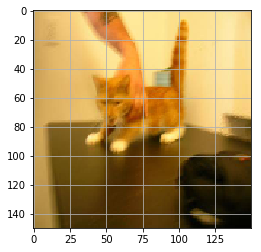

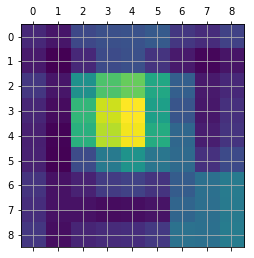

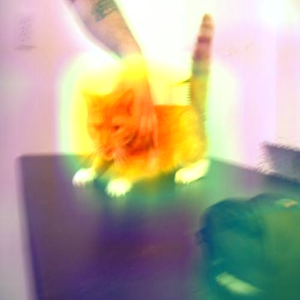

In [108]:
process_image(img_path1)

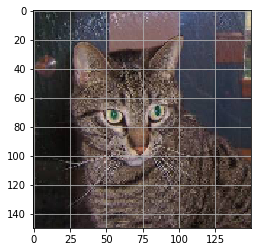

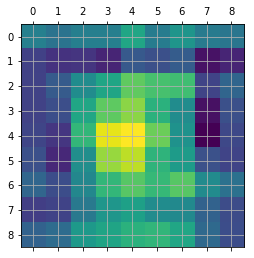

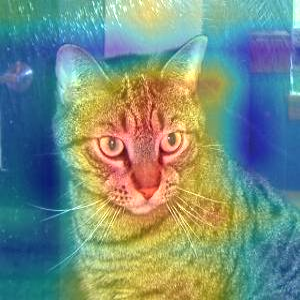

In [109]:
process_image(img_path2)

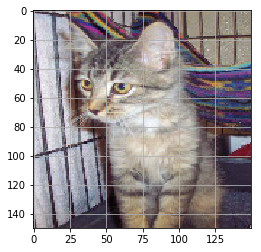

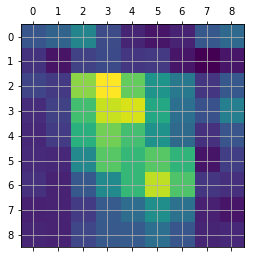

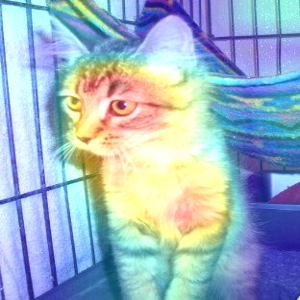

In [110]:
process_image(img_path3)

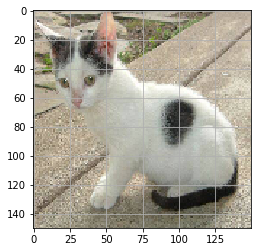

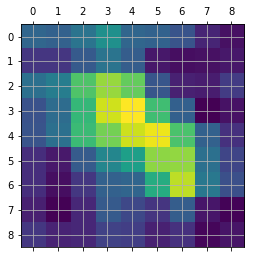

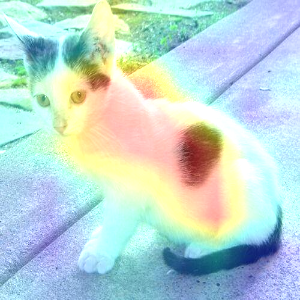

In [111]:
process_image(img_path4)

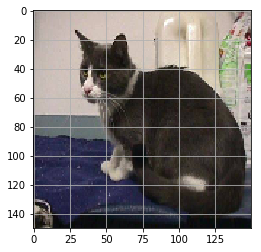

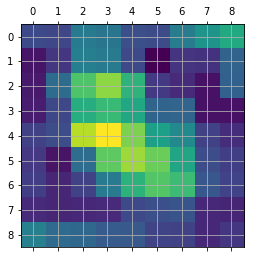

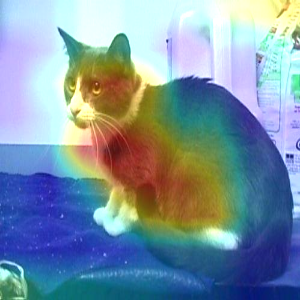

In [112]:
process_image(img_path5)

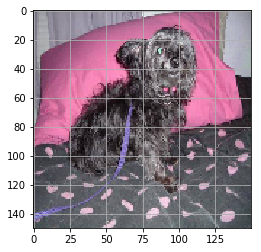

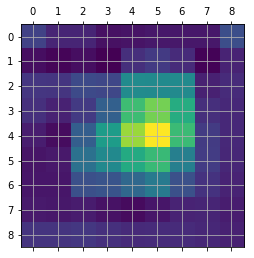

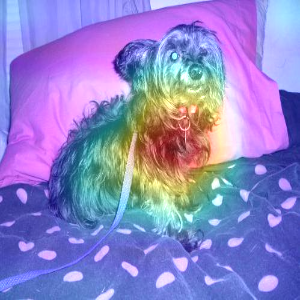

In [113]:
process_image(img_path6)

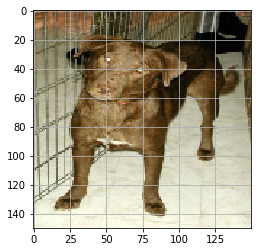

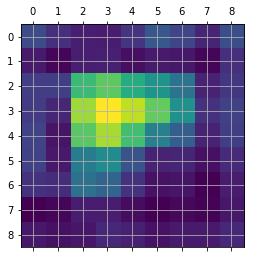

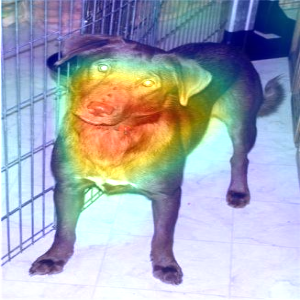

In [114]:
process_image(img_path7)

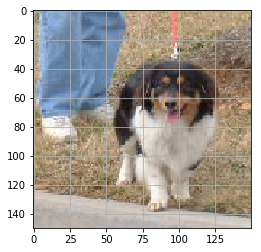

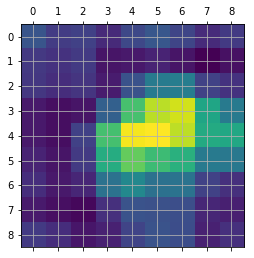

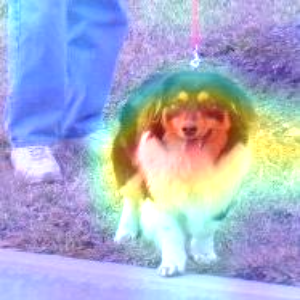

In [115]:
process_image(img_path8)

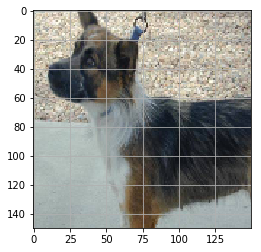

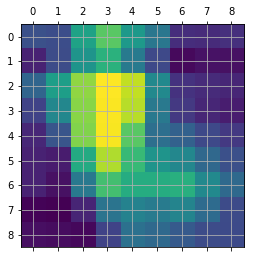

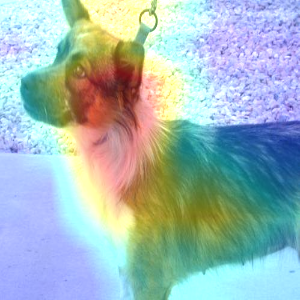

In [116]:
process_image(img_path9)

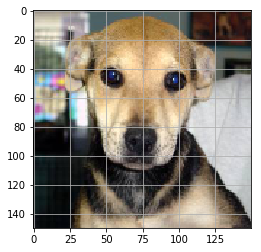

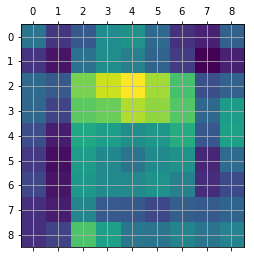

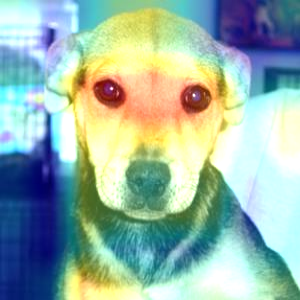

In [117]:
process_image(img_path10)

# Problem 4

In [0]:
import time
import seaborn as sns
from sklearn.manifold import TSNE
import matplotlib.patheffects as PathEffects

In [119]:
validation_datagen = ImageDataGenerator(rescale=1./255)
# create a validation set that 
# can be placed into a tuple
validation_generator = next(validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=350,
    class_mode='binary'))

# tuple to hold the data for the
# activation model
imgs, labels = validation_generator
layer = model.get_layer('dense_2')
layer_output = layer.output
activation_model = models.Model(input=model.input, outputs=[layer_output])

# predict the images
activations = activation_model.predict(imgs)

Found 1000 images belonging to 2 classes.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=Tensor("in...)`
  from ipykernel import kernelapp as app


In [0]:
# same methodology as 
# Dr. Wocjan's t-SNE program 
# for MNIST fashion data
def data_scatter(vecs, labels):
    num_classes = len(np.unique(labels))
    palette = np.array(sns.color_palette("husl", num_classes))
    f = plt.figure(figsize=(12, 12))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(vecs[:, 0], vecs[:, 1], c=palette[labels.astype(int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    for idx in range(num_classes):
        x_coord, y_coord = np.median(vecs[labels == idx, :], axis=0)
        txt = ax.text(x_coord, y_coord, class_names[idx], fontsize=16)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=6, foreground="w"),
            PathEffects.Normal()])

t-SNE done! Time elapsed: 1.7567343711853027 seconds


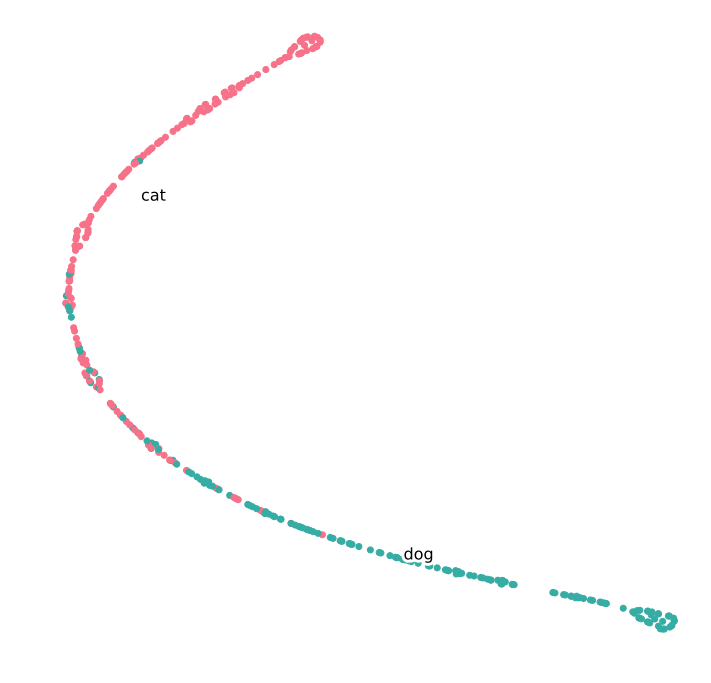

In [121]:
time_start = time.time()
data = TSNE(random_state=42).fit_transform(activations)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time() - time_start))

# this produces an odd curve for classification,
# but correctly places them into two 
# classification groups
data_scatter(data, labels)